**Import Libraries and Mount To Google Drive To Get The Dataset**

In [1]:
#Reference 
#https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwju1MOJ8qv8AhWUSPEDHdoWDCkQFnoECA0QAQ&url=https%3A%2F%2Fmedium.com%2Fluca-chuangs-bapm-notes%2Fbuild-a-neural-network-in-python-regression-a80a906f634c&usg=AOvVaw0EJ1dJOGyoYU6aul8pNHCP

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

# Neural Net modules
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

from tensorflow.config.experimental import list_physical_devices

from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
from IPython.display import clear_output
import zipfile
import os
import time

In [ ]:
print('GPU name: ', list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


**Prepare The Dataset**

In [3]:
%cd MyDrive

!unzip 'AAML/dataset.zip' -d 'AAML/'

if os.path.exists('AAML/dataset.csv'):
  dataframe = pd.read_csv('AAML/dataset.csv')
  if "Unnamed: 0" in dataframe:
    dataframe.drop("Unnamed: 0", inplace=True, axis=1)

/gdrive/MyDrive
Archive:  AAML/dataset.zip
replace AAML/dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: AAML/dataset.csv        


,top_left_r,top_left_g,top_left_b,top_left_a,top_r,top_g,top_b,top_a,top_right_r,top_right_b,...,bottom_b,bottom_a,bottom_right_r,bottom_right_g,bottom_right_b,bottom_right_a,middle_r,middle_g,middle_b,middle_a
0,20,41,60,255,19,40,61,255,20,40,...,59,255,18,39,60,255,18,39,60,255
1,19,40,61,255,20,40,64,255,19,40,...,60,255,18,39,60,255,18,39,60,255
2,20,40,64,255,19,40,61,255,21,41,...,60,255,17,38,59,255,18,39,60,255
3,19,40,61,255,21,41,65,255,21,41,...,59,255,19,40,61,255,18,38,62,255
4,21,41,65,255,21,41,66,255,22,40,...,61,255,17,38,59,255,18,38,62,255


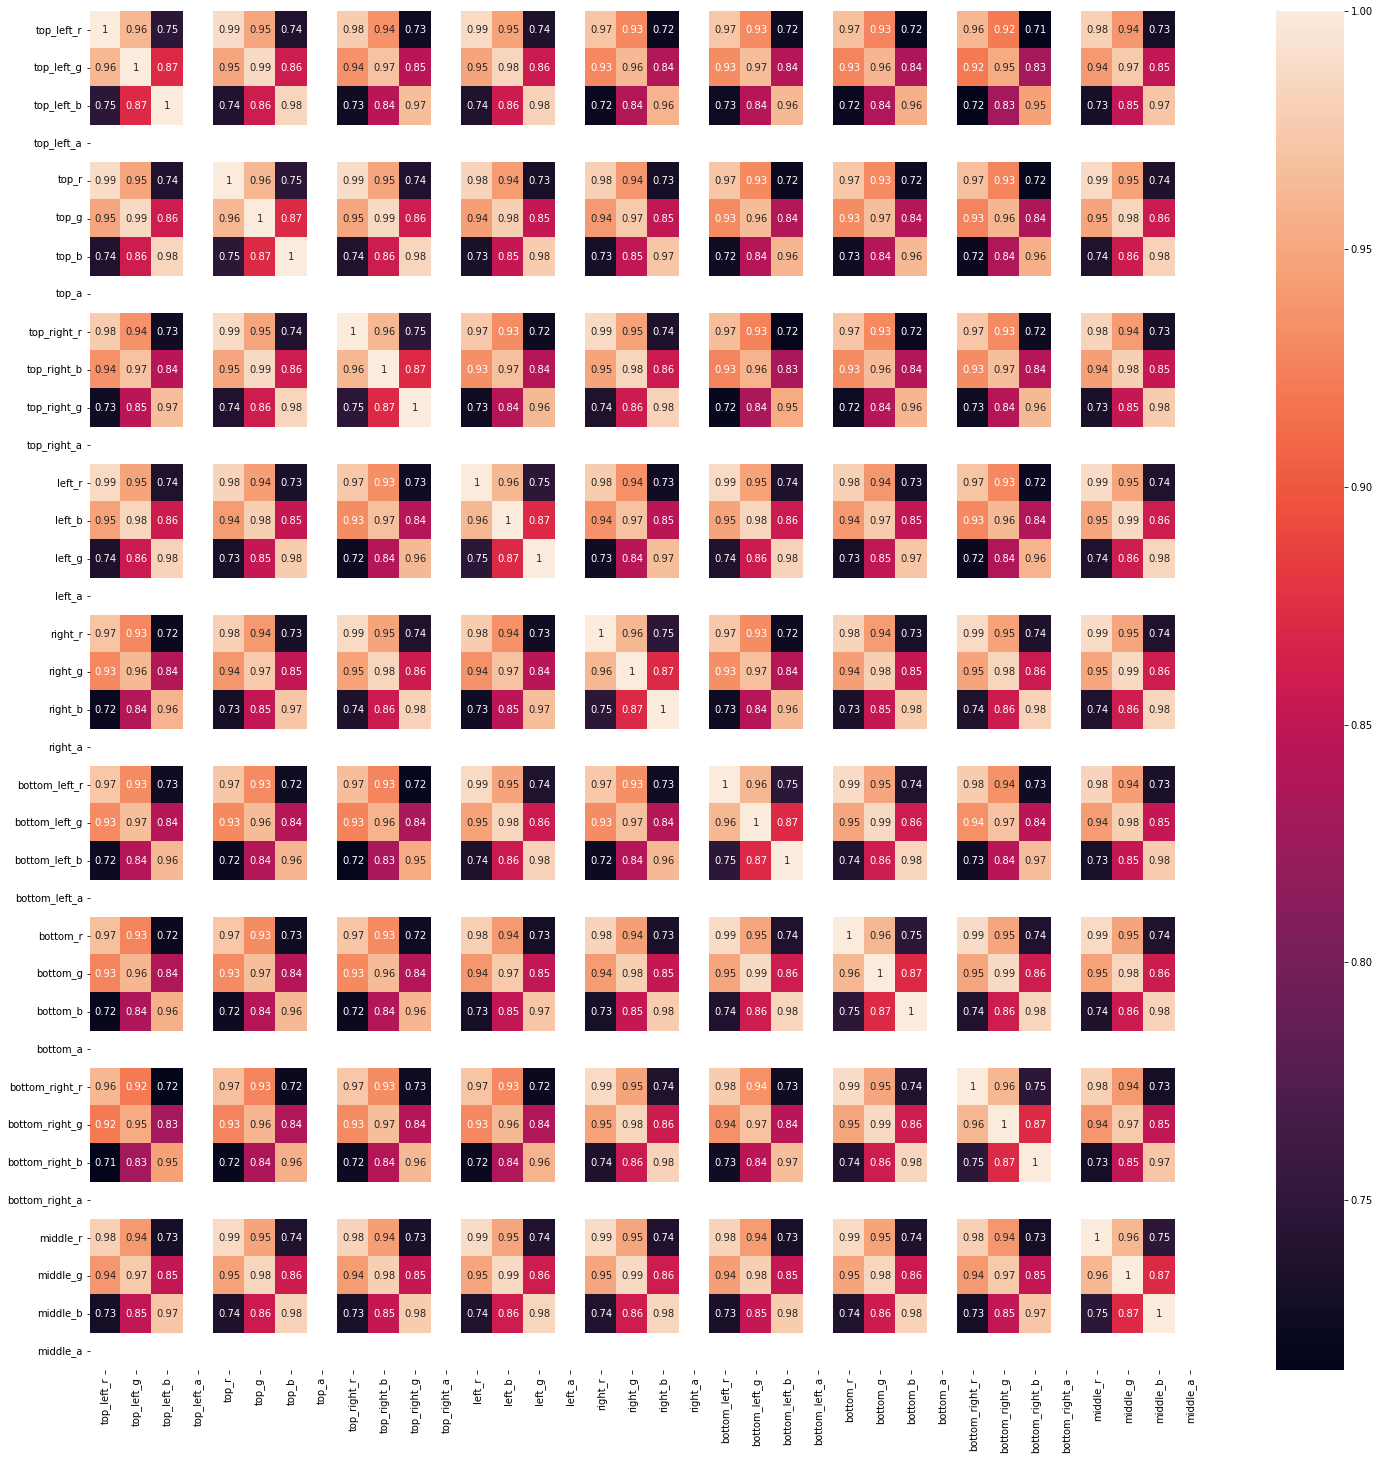

In [7]:
plt.figure(figsize=(25, 25))
sns.heatmap(dataframe.corr(), annot=True)
dataframe.head()

In [ ]:
Y = dataframe.iloc[:, 32:36]
X = dataframe.iloc[:, 0:32]
print(X.shape, Y.shape)

X = np.array(X)
Y = np.array(Y)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(2291251, 32) (2291251, 4)
(1603875, 32) (687376, 32) (1603875, 4) (687376, 4)


**Train The Dataset**

In [ ]:
import os

model = None

if os.path.exists('AAML/model'):
  model = load_model('AAML/model')
else:
  model = Sequential()
  model.add(Dense(512, input_shape=(x_train.shape[1],), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='linear'))
  model.summary()
  
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)

history = model.fit(x_train, y_train, 
                    validation_data=(x_test, y_test), 
                    callbacks=[early_stop],
                    epochs=20,
                    batch_size=50,
                    verbose=1)

Epoch 1/20
32078/32078 [==============================] - 157s 5ms/step - loss: 303.9313 - mae: 12.6516 - val_loss: 309.6613 - val_mae: 12.0131
Epoch 2/20
32078/32078 [==============================] - 158s 5ms/step - loss: 281.5434 - mae: 11.9265 - val_loss: 180.7525 - val_mae: 9.3823
Epoch 3/20
32078/32078 [==============================] - 154s 5ms/step - loss: 261.1450 - mae: 11.1166 - val_loss: 162.0902 - val_mae: 8.6637
Epoch 4/20
32078/32078 [==============================] - 157s 5ms/step - loss: 246.2402 - mae: 10.2504 - val_loss: 166.2831 - val_mae: 8.8139
Epoch 5/20
32078/32078 [==============================] - 157s 5ms/step - loss: 241.3809 - mae: 10.0131 - val_loss: 156.5886 - val_mae: 8.4993
Epoch 6/20
32078/32078 [==============================] - 136s 4ms/step - loss: 240.7945 - mae: 9.9787 - val_loss: 207.1649 - val_mae: 9.6917
Epoch 7/20
32078/32078 [==============================] - 140s 4ms/step - loss: 240.1740 - mae: 9.9727 - val_loss: 209.1673 - val_mae: 9.7759


In [ ]:
model.save('AAML/model')

**Make Predictions and Show That on Graphs**

In [ ]:
# Predict
model = load_model('AAML/model')
predictions = model.predict(x_test)
print(f"Prediction : {predictions[0]}\nReal value : {y_test[0]}")

21481/21481 [==============================] - 40s 2ms/step
Prediction : [154.61072 133.73462 119.39468 254.6407 ]
Real value : [136 107 112 255]


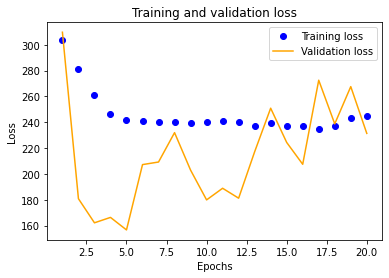

In [ ]:
# let's see the training and validation accuracy by epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

21481/21481 [==============================] - 33s 2ms/step


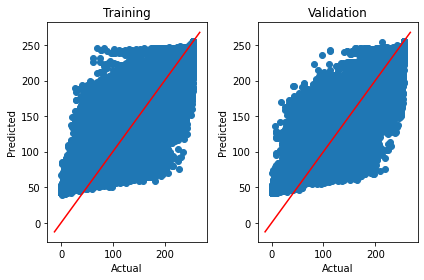

In [ ]:
# scatterplot of actual vs. pred
# specify the dimensions 
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=y_train, y=model.predict(x_train)) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test, y=model.predict(x_test)) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

Test on The Image

In [ ]:
class Timer: 
  
  def Start(self):
    self.start = time.perf_counter()

  def End(self, testName):
    self.end = time.perf_counter()
    print(f"{testName} : {self.end - self.start}")

  start = None
  end = None

In [ ]:
def GetXNumpyArray(_list):
  ndArray = np.array(_list)
  return np.reshape(ndArray, (len(_list), 32))

def GetPredictTupleList(predict_list):
  result_tuple = []
  for i in range(0, predict_list.shape[0]):
    result = predict_list[i]
    result = [round(pixel) for pixel in result]
    result_tuple.append(tuple(result))
  return result_tuple

class TestImage:
  def __init__(self, image_path):
    self.image_path = image_path

  def LoadImage(self):
    if self.image:
      self.image.close()

    self.image = Image.open(self.image_path)
    
    if self.image.mode == 'RGB':
      self.image = self.image.convert('RGBA')

    self.pixels = self.image.load()
    self.width = self.image.width
    self.height = self.image.height
    

  def __del__(self):
    if self.image:
      self.image.close()

  def DoTestWithFullImage(self, model):
    self.LoadImage()

    pixelList = []
    to_predict = []

    for y in tqdm(range(1, self.height - 1), desc="Getting Pixel Values"):
      for x in range(1, self.width - 1):
        pixelList.extend(self.pixels[x - 1, y - 1]) # top_left
        pixelList.extend(self.pixels[x    , y - 1]) # top
        pixelList.extend(self.pixels[x + 1, y - 1]) # top_right
        pixelList.extend(self.pixels[x - 1, y    ]) # left
        pixelList.extend(self.pixels[x + 1, y    ]) # right
        pixelList.extend(self.pixels[x - 1, y + 1]) # bottom_left
        pixelList.extend(self.pixels[x    , y + 1]) # bottom
        pixelList.extend(self.pixels[x + 1, y + 1]) # bottom_right

        array = np.array(pixelList)
        array = np.reshape(array, (1, 32))

        to_predict.append(array)
        pixelList.clear()

    to_predict_nd = GetXNumpyArray(to_predict)
    predict = model.predict(to_predict_nd)
    result_tuple = GetPredictTupleList(predict)

    index = 0
    for y in tqdm(range(1, self.height - 1), desc="Writing Pixel Values"):
      for x in range(1, self.width - 1):
        self.pixels[x, y] = result_tuple[index]
        index = index + 1

    display(self.image)

  def DoTestWithRowRow(self, model):
    self.LoadImage()

    pixelList = []
    to_predict = []

    for y in tqdm(range(1, self.height - 1), desc="Predicting"):
      for x in range(1, self.width - 1):
        pixelList.extend(self.pixels[x - 1, y - 1]) # top_left
        pixelList.extend(self.pixels[x    , y - 1]) # top
        pixelList.extend(self.pixels[x + 1, y - 1]) # top_right
        pixelList.extend(self.pixels[x - 1, y    ]) # left
        pixelList.extend(self.pixels[x + 1, y    ]) # right
        pixelList.extend(self.pixels[x - 1, y + 1]) # bottom_left
        pixelList.extend(self.pixels[x    , y + 1]) # bottom
        pixelList.extend(self.pixels[x + 1, y + 1]) # bottom_right

        array = np.array(pixelList)
        array = np.reshape(array, (1, 32))

        to_predict.append(array)
        pixelList.clear()
    
      to_predict_nd = GetXNumpyArray(to_predict)
      predict = model.predict(to_predict_nd, verbose=0)
      result_tuple = GetPredictTupleList(predict)

      index = 0
      for i in range(1, self.width - 1):
        self.pixels[i, y] = result_tuple[index]
        index = index + 1

      to_predict.clear()
    
    display(self.image)

  image_path = None
  image = None
  pixels = None
  width = None
  height = None


Predicting:   0%|          | 0/581 [00:00<?, ?it/s]

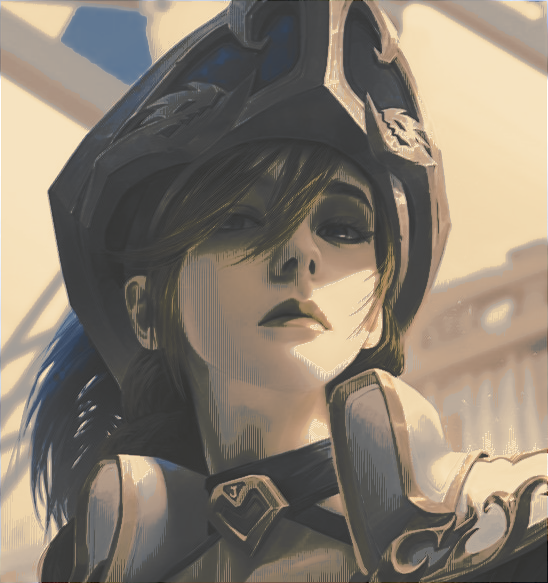

Getting Pixel Values:   0%|          | 0/581 [00:00<?, ?it/s]

9914/9914 [==============================] - 17s 2ms/step


Writing Pixel Values:   0%|          | 0/581 [00:00<?, ?it/s]

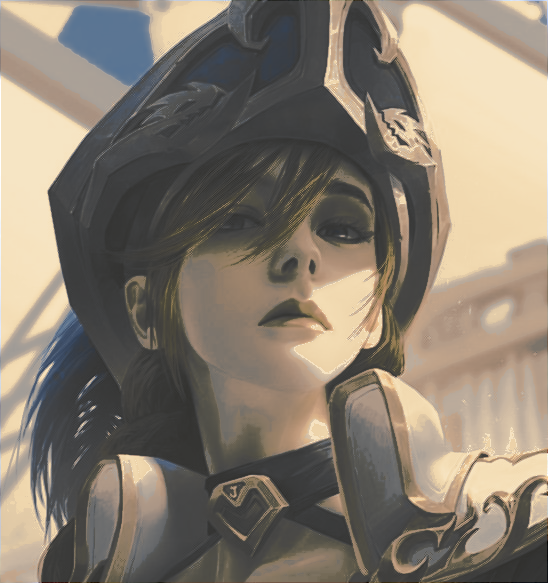

In [ ]:
model = load_model('AAML/model')

test_image = TestImage('AAML/test.jpg')
test_image.DoTestWithRowRow(model)
test_image.DoTestWithFullImage(model)